In [31]:
import os

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import GroupKFold
from sklearn.utils import check_random_state

plt.rcParams["figure.figsize"] = (9, 4)
plt.rcParams["axes.grid"] = True

RANDOM_STATE = 42
rng = check_random_state(RANDOM_STATE)

DATA_TRANSFORMED = "../data/transformed"
TRAIN_FEAT = os.path.join(DATA_TRANSFORMED, "train-features.parquet")
TEST_FEAT = os.path.join(DATA_TRANSFORMED, "test-features.parquet")

MODEL_DIR = "../models"
os.makedirs(MODEL_DIR, exist_ok=True)


In [32]:
def downcast_df(df: pd.DataFrame) -> pd.DataFrame:
    for c in df.select_dtypes(include=["float64"]).columns:
        df[c] = df[c].astype("float32")
    for c in df.select_dtypes(include=["int64", "int32"]).columns:
        if c == "item_contact":
            df[c] = df[c].astype("int8")
        else:
            df[c] = df[c].astype("int32")
    return df


train = pd.read_parquet(TRAIN_FEAT)
test = pd.read_parquet(TEST_FEAT)

train = downcast_df(train)
test = downcast_df(test)

print(train.shape, test.shape)
train.head()


(113756, 30) (335348, 29)


,query_id,item_id,item_contact,price_log,price_norm,is_free,price_rank_in_query,query_text_len_words,item_title_len_words,item_description_len_words,...,price_z_in_query,title_len_per_query,desc_len_per_query,q_in_title_jacc,q_in_desc_jacc,click_conv_log_z_in_query,tfidf_cosine_desc,item_cat_loc_freq,bm25_title,bm25_desc
0,184,-794457995,0,6.216606,0.5,0,0.65,2,2,21,...,0.165307,1.0,10.5,1.000000,0.111111,-0.029362,0.430331,0.000123,0.459656,1.342589
1,184,-1351814045,1,6.216606,0.5,0,0.65,2,4,85,...,0.165307,2.0,42.5,0.000000,0.000000,0.982877,0.000000,0.000123,0.000000,0.000000
2,184,-1887551359,0,4.615120,0.1,0,0.15,2,3,19,...,-1.232638,1.5,9.5,0.666667,0.111111,1.508196,0.284747,0.000123,0.397540,1.036910
3,184,-1813532597,1,5.303305,0.2,0,0.30,2,3,16,...,-0.883151,1.5,8.0,0.666667,0.133333,1.560451,0.311086,0.000123,0.397540,1.087318
4,184,-1053692811,0,4.615120,0.1,0,0.15,2,3,15,...,-1.232638,1.5,7.5,0.000000,0.000000,-0.896566,0.000000,0.000123,0.000000,0.000000


In [33]:
ID_COLS = ["query_id", "item_id"]
TARGET_COL = "item_contact"

FEATURE_COLS = [c for c in train.columns if c not in ID_COLS + [TARGET_COL]]

X = train[FEATURE_COLS].copy()
y = train[TARGET_COL].astype("float32").values
groups = train["query_id"].values

print("n_features:", len(FEATURE_COLS))
FEATURE_COLS


n_features: 27


['price_log',
 'price_norm',
 'is_free',
 'price_rank_in_query',
 'query_text_len_words',
 'item_title_len_words',
 'item_description_len_words',
 'q_in_title_frac',
 'q_in_desc_frac',
 'match_cat',
 'match_mcat',
 'match_loc',
 'tfidf_cosine_title',
 'query_loc_freq',
 'item_loc_freq',
 'item_cat_id_freq',
 'item_mcat_id_freq',
 'price_z_in_query',
 'title_len_per_query',
 'desc_len_per_query',
 'q_in_title_jacc',
 'q_in_desc_jacc',
 'click_conv_log_z_in_query',
 'tfidf_cosine_desc',
 'item_cat_loc_freq',
 'bm25_title',
 'bm25_desc']

In [34]:
def calc_dcg_at_k(v: np.ndarray, k: int = 10) -> float:
    w = 0.97 ** np.arange(len(v))
    return (v * w)[:k].sum()


def calc_idcg_at_k(v: np.ndarray, k: int = 10) -> float:
    return calc_dcg_at_k(np.sort(v)[::-1], k)


def calc_ndcg_at_k(v: np.ndarray, k: int = 10) -> float:
    denom = calc_idcg_at_k(v, k)
    if denom == 0:
        return 0.0
    return calc_dcg_at_k(v, k) / denom


def ndcg_at_10_by_queries(
    y_true: np.ndarray, y_pred: np.ndarray, qids: np.ndarray, k: int = 10
) -> float:
    order = np.argsort(qids, kind="mergesort")
    qids_sorted = qids[order]
    y_true_s = y_true[order]
    y_pred_s = y_pred[order]

    uniq, starts = np.unique(qids_sorted, return_index=True)
    starts = list(starts) + [len(qids_sorted)]

    scores = []
    for i in range(len(uniq)):
        s, e = starts[i], starts[i + 1]
        yt = y_true_s[s:e]
        yp = y_pred_s[s:e]
        idx = np.argsort(-yp, kind="mergesort")
        v = yt[idx]
        scores.append(calc_ndcg_at_k(v, k))
    return float(np.mean(scores)) if scores else 0.0


def lgbm_ndcg10_custom(preds, dataset):
    """
    preds: np.ndarray, предсказанные скоры
    dataset: lgb.Dataset
    Возвращает tuple (имя, значение, is_higher_better)
    """
    y_true = dataset.get_label().astype(np.int32)
    group = dataset.get_group()  # массив размеров групп (сумма = len(y_true))

    # Восстановим qids для удобства (0,0,0,...,1,1,1,...)
    qids = np.repeat(np.arange(len(group)), group)

    score = ndcg_at_10_by_queries(y_true, preds, qids, k=10)
    return "ndcg10_custom", score, True

In [35]:
N_SPLITS = 5
gkf = GroupKFold(n_splits=N_SPLITS)

params = {
    "objective": "lambdarank",
    "label_gain": [0, 1],  # бинарный таргет
    "lambdarank_truncation_level": 10,  # фокус на топ-10
    "metric": "None",
    "eval_at": [10],
    "learning_rate": 0.05,
    "num_leaves": 63,
    "max_depth": -1,
    "min_data_in_leaf": 200,
    "min_gain_to_split": 0.0,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq": 1,
    "lambda_l2": 2.0,
    "lambda_l1": 0.0,
    "max_bin": 255,
    "verbosity": -1,
    "random_state": RANDOM_STATE,
    "deterministic": True,
    "force_row_wise": True,
}


oof_pred = np.zeros(len(train), dtype=np.float32)
models = []
fold_scores = []

for fold, (tr_idx, va_idx) in enumerate(gkf.split(X, y, groups), 1):
    X_tr, y_tr, q_tr = X.iloc[tr_idx], y[tr_idx], groups[tr_idx]
    X_va, y_va, q_va = X.iloc[va_idx], y[va_idx], groups[va_idx]

    def group_sizes(qids):
        _, counts = np.unique(qids, return_counts=True)
        return counts

    lgb_tr = lgb.Dataset(X_tr, y_tr, group=group_sizes(q_tr), free_raw_data=False)
    lgb_va = lgb.Dataset(
        X_va, y_va, group=group_sizes(q_va), reference=lgb_tr, free_raw_data=False
    )

    booster = lgb.train(
        params,
        lgb_tr,
        num_boost_round=5000,
        valid_sets=[lgb_tr, lgb_va],
        valid_names=["train", "valid"],
        callbacks=[
            lgb.early_stopping(stopping_rounds=100, verbose=False),
            lgb.log_evaluation(period=100),
        ],
        feval=lgbm_ndcg10_custom,
    )

    pred_va = booster.predict(X_va, num_iteration=booster.best_iteration)
    oof_pred[va_idx] = pred_va

    ndcg10 = ndcg_at_10_by_queries(y_va, pred_va, q_va, k=10)
    fold_scores.append(ndcg10)
    models.append(booster)


[100]	train's ndcg10_custom: 0.344265	valid's ndcg10_custom: 0.274348
[100]	train's ndcg10_custom: 0.346768	valid's ndcg10_custom: 0.273076
[200]	train's ndcg10_custom: 0.352929	valid's ndcg10_custom: 0.272616
[100]	train's ndcg10_custom: 0.340898	valid's ndcg10_custom: 0.283467
[200]	train's ndcg10_custom: 0.347	valid's ndcg10_custom: 0.282788
[100]	train's ndcg10_custom: 0.338882	valid's ndcg10_custom: 0.279005
[100]	train's ndcg10_custom: 0.338509	valid's ndcg10_custom: 0.282034
[200]	train's ndcg10_custom: 0.344364	valid's ndcg10_custom: 0.282548


OOF NDCG@10 (на всех фолдах): 0.28090


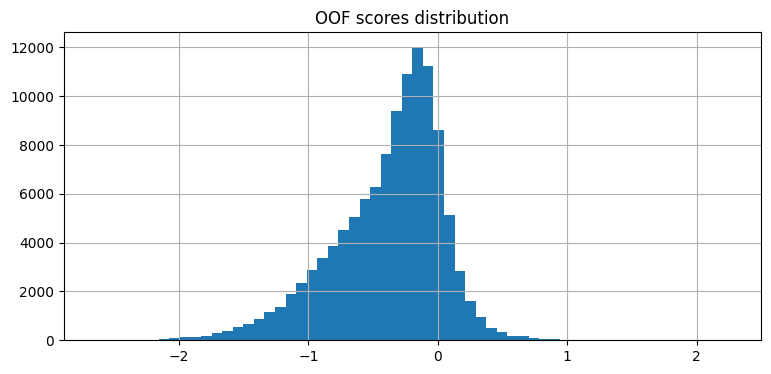

In [36]:
oof_ndcg10 = ndcg_at_10_by_queries(y_true=y, y_pred=oof_pred, qids=groups, k=10)
print(f"OOF NDCG@10 (на всех фолдах): {oof_ndcg10:.5f}")

plt.figure()
plt.hist(oof_pred, bins=60)
plt.title("OOF scores distribution")
plt.show()


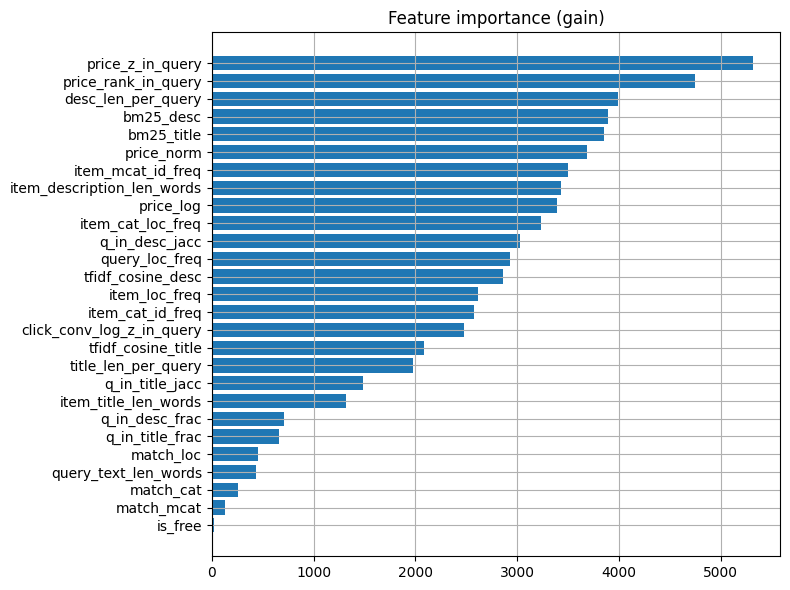

,feature,gain
17,price_z_in_query,5317.004257
3,price_rank_in_query,4744.035742
19,desc_len_per_query,3993.741286
26,bm25_desc,3893.305009
25,bm25_title,3856.788825
1,price_norm,3688.822091
16,item_mcat_id_freq,3500.461874
6,item_description_len_words,3432.308968
0,price_log,3390.371475
24,item_cat_loc_freq,3230.722166


In [37]:
importances = pd.DataFrame(
    {
        "feature": FEATURE_COLS,
        "gain": np.mean(
            [m.feature_importance(importance_type="gain") for m in models], axis=0
        ),
    }
)
imp_top = importances.sort_values("gain", ascending=False)

plt.figure(figsize=(8, 6))
plt.barh(imp_top["feature"][::-1], imp_top["gain"][::-1])
plt.title("Feature importance (gain)")
plt.tight_layout()
plt.show()

imp_top


In [38]:
def group_sizes_ordered(qids: np.ndarray) -> np.ndarray:
    _, counts = np.unique(qids, return_counts=True)
    return counts


train_full = lgb.Dataset(X, y, group=group_sizes_ordered(groups), free_raw_data=False)

final_model = lgb.train(
    params,
    train_full,
    num_boost_round=int(np.mean([m.best_iteration for m in models])),
    valid_sets=[train_full],
    valid_names=["train"],
    callbacks=[lgb.log_evaluation(period=200)],
)

final_path = os.path.join(MODEL_DIR, "lgbm_ranker.txt")
final_model.save_model(final_path)
print("Saved model to:", final_path)


Saved model to: ../models/lgbm_ranker.txt


In [39]:
oof_df = train[["query_id", "item_id", TARGET_COL]].copy()
oof_df["oof_score"] = oof_pred.astype("float32")
oof_out = os.path.join(DATA_TRANSFORMED, "oof_scores.parquet")
oof_df.to_parquet(oof_out, index=False)
print("Saved OOF:", oof_out)

test_scores = test[["query_id", "item_id"]].copy()
test_scores["score"] = final_model.predict(test[FEATURE_COLS])
test_out = os.path.join(DATA_TRANSFORMED, "test_scores.parquet")
test_scores.to_parquet(test_out, index=False)
print("Saved test scores:", test_out)


Saved OOF: ../data/transformed/oof_scores.parquet
Saved test scores: ../data/transformed/test_scores.parquet


In [40]:
sub = test_scores.sort_values(["query_id", "score"], ascending=[True, False])[
    ["query_id", "item_id"]
]
sub_path = os.path.join("../data", "solution.csv")
sub.to_csv(sub_path, header=["query_id", "item_id"], index=False)
print("Saved submission:", sub_path)
sub.head()


Saved submission: ../data/solution.csv


,query_id,item_id
8,55,-1037870576
6,55,-996537386
1,55,-1083214256
0,55,-1049078803
27,55,-1013267697
